# Lung Disease Detection using CNN
We use the Chest X-Ray dataset (NORMAL vs PNEUMONIA) to train a convolutional neural network.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install matplotlib numpy scikit-learn


  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.0-cp39-cp39-win_amd64.whl.metadata (113 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.3.0-cp39-cp39-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.4-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl (211 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.0-cp39-cp39-win_amd64.whl (1.5 MB)
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl (55 kB)
Using cached pillow-11.3.0-cp39-cp39-win_amd64.whl (7.0 MB)
Us

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report

DATA_DIR = "DATA/chest_xray"
IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))



TensorFlow: 2.15.0
GPU available: []


In [ ]:
# Step 3 — Load Dataset (from folder structure)
from tensorflow import keras
import tensorflow as tf
import os

DATA_DIR = "DATA/chest_xray"
IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

train_ds = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED
)
val_ds = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/val",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)
test_ds = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/test",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

# ✅ Save class names BEFORE prefetch
class_names = train_ds.class_names
print("Classes:", class_names)

# optional: performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# quick sanity checks
n_train = sum(1 for _ in train_ds.unbatch())
n_val   = sum(1 for _ in val_ds.unbatch())
n_test  = sum(1 for _ in test_ds.unbatch())
print(f"Samples -> train: {n_train}, val: {n_val}, test: {n_test}")



Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']
Samples -> train: 5216, val: 16, test: 624


C:\Users\dyuti\AppData\Local\Temp\ipykernel_27536\3958140088.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(labels[i].numpy())])


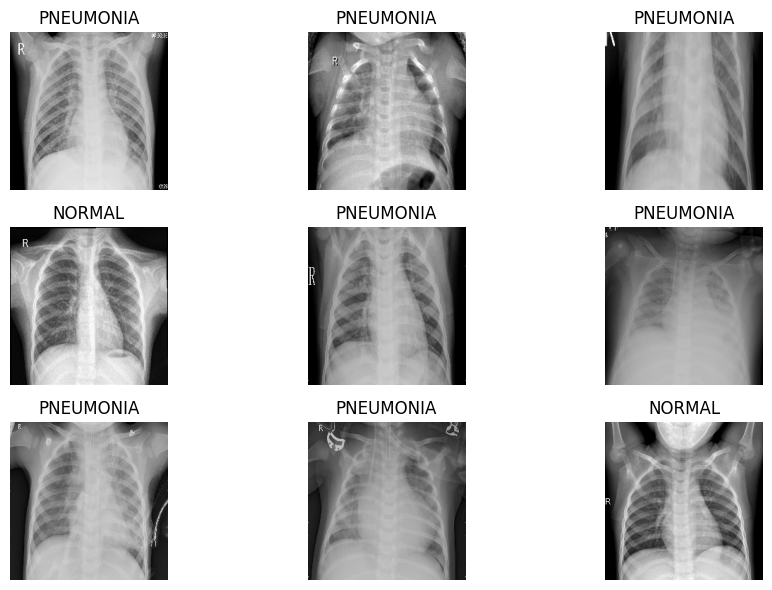

In [ ]:
# peek at samples
import matplotlib.pyplot as plt
images, labels = next(iter(train_ds))
plt.figure(figsize=(10,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i].numpy())])
    plt.axis("off")
plt.tight_layout(); plt.show()


In [ ]:
import os
n_normal    = len(os.listdir(f"{DATA_DIR}/train/NORMAL"))
n_pneumonia = len(os.listdir(f"{DATA_DIR}/train/PNEUMONIA"))
total = n_normal + n_pneumonia
class_weight = {
    0: total/(2*n_normal),     # NORMAL
    1: total/(2*n_pneumonia)   # PNEUMONIA
}
print("class_weight:", class_weight)


class_weight: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = (224, 224)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomZoom(0.1),
], name="augmentation")

base = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # stage 1: freeze the backbone

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Recall(name="recall")]
)
model.summary()




9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                      

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,                 # bump later if you like
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/6


163/163 [==============================] - 55s 322ms/step - loss: 0.3587 - accuracy: 0.8345 - auc: 0.9234 - recall: 0.8317 - val_loss: 0.4085 - val_accuracy: 0.7500 - val_auc: 0.9844 - val_recall: 1.0000
Epoch 2/6
163/163 [==============================] - 51s 310ms/step - loss: 0.1904 - accuracy: 0.9264 - auc: 0.9795 - recall: 0.9203 - val_loss: 0.3637 - val_accuracy: 0.8125 - val_auc: 0.9688 - val_recall: 1.0000
Epoch 3/6
163/163 [==============================] - 51s 311ms/step - loss: 0.1531 - accuracy: 0.9438 - auc: 0.9868 - recall: 0.9378 - val_loss: 0.3253 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_recall: 1.0000
Epoch 4/6
163/163 [==============================] - 51s 311ms/step - loss: 0.1424 - accuracy: 0.9421 - auc: 0.9882 - recall: 0.9370 - val_loss: 0.2849 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_recall: 1.0000


20/20 [==============================] - 6s 267ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.41      0.57       234
   PNEUMONIA       0.74      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624



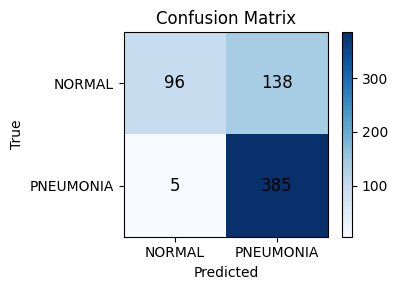

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# collect ground-truth and predictions
y_true = np.concatenate([y for _, y in test_ds], axis=0).astype(int).ravel()
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], class_names)
plt.yticks([0,1], class_names)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


In [ ]:
# unfreeze the last ~30 layers for a short fine-tune
for layer in base.layers[:-30]:
    layer.trainable = False
for layer in base.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # smaller LR for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Recall(name="recall")]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=4,
    class_weight=class_weight,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=2, restore_best_weights=True)]
)

print("Re-evaluating after fine-tune:")
print(model.evaluate(test_ds, return_dict=True))



Epoch 1/4
163/163 [==============================] - 53s 311ms/step - loss: 0.2083 - accuracy: 0.9195 - auc: 0.9768 - recall: 0.9133 - val_loss: 0.3629 - val_accuracy: 0.8125 - val_auc: 0.9688 - val_recall: 1.0000
Epoch 2/4
163/163 [==============================] - 52s 317ms/step - loss: 0.1961 - accuracy: 0.9231 - auc: 0.9798 - recall: 0.9148 - val_loss: 0.3834 - val_accuracy: 0.7500 - val_auc: 0.9688 - val_recall: 1.0000
Epoch 3/4
163/163 [==============================] - 51s 309ms/step - loss: 0.1856 - accuracy: 0.9291 - auc: 0.9818 - recall: 0.9234 - val_loss: 0.3689 - val_accuracy: 0.7500 - val_auc: 0.9688 - val_recall: 1.0000
Re-evaluating after fine-tune:
20/20 [==============================] - 5s 265ms/step - loss: 0.3905 - accuracy: 0.8109 - auc: 0.9498 - recall: 0.9821
{'loss': 0.3905276358127594, 'accuracy': 0.8108974099159241, 'auc': 0.9498192071914673, 'recall': 0.9820512533187866}


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# gather labels & probs from test_ds (already batched)
y_true = np.concatenate([y for _, y in test_ds]).astype(int).ravel()
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob >= 0.5).astype(int)

prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)              # should match your recall metric
f1   = f1_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp + 1e-9)

print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | Specificity: {specificity:.3f}")
print("Confusion matrix [tn, fp; fn, tp]:", [[tn, fp],[fn, tp]])


20/20 [==============================] - 6s 277ms/step
Precision: 0.775 | Recall: 0.982 | F1: 0.867 | Specificity: 0.526
Confusion matrix [tn, fp; fn, tp]: [[123, 111], [7, 383]]


In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve

# Precision-Recall curve to find F1-optimal threshold
precisions, recalls, pr_thresholds = precision_recall_curve(y_true, y_prob)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = pr_thresholds[best_idx] if best_idx < len(pr_thresholds) else 0.5
print(f"Best F1 threshold: {best_thr:.3f}, F1={f1s[best_idx]:.3f}, P={precisions[best_idx]:.3f}, R={recalls[best_idx]:.3f}")

# Apply it
y_pred_opt = (y_prob >= best_thr).astype(int)
print("Precision/Recall @best_thr:",
      precision_score(y_true, y_pred_opt), recall_score(y_true, y_pred_opt))


Best F1 threshold: 0.776, F1=0.912, P=0.892, R=0.933
Precision/Recall @best_thr: 0.8921568627450981 0.9333333333333333


In [ ]:
from tensorflow import keras

IMG_SIZE = (224, 224); BATCH = 32; SEED = 42
DATA_DIR = "DATA/chest_xray"

# Make a new train/val from the training folder using validation_split
train_ds2 = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    validation_split=0.1,      # 10% of train as validation
    subset="training"
)
val_ds2 = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    validation_split=0.1,
    subset="validation"
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds2 = train_ds2.prefetch(AUTOTUNE)
val_ds2   = val_ds2.prefetch(AUTOTUNE)


Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.


In [ ]:
# fine-tune with lighter bias
for layer in base.layers[:-30]:
    layer.trainable = False
for layer in base.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Recall(name="recall")]
)

history_ft = model.fit(
    train_ds2,                 # <- the bigger validation split
    validation_data=val_ds2,
    epochs=5,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=2, restore_best_weights=True)]
)


Epoch 1/5
147/147 [==============================] - 55s 356ms/step - loss: 0.1739 - accuracy: 0.9382 - auc: 0.9791 - recall: 0.9589 - val_loss: 0.1800 - val_accuracy: 0.9386 - val_auc: 0.9795 - val_recall: 0.9873
Epoch 2/5
147/147 [==============================] - 51s 347ms/step - loss: 0.1650 - accuracy: 0.9393 - auc: 0.9811 - recall: 0.9612 - val_loss: 0.1682 - val_accuracy: 0.9443 - val_auc: 0.9786 - val_recall: 0.9848
Epoch 3/5
147/147 [==============================] - 51s 347ms/step - loss: 0.1618 - accuracy: 0.9391 - auc: 0.9818 - recall: 0.9629 - val_loss: 0.1688 - val_accuracy: 0.9443 - val_auc: 0.9791 - val_recall: 0.9873


In [ ]:
model.save("lung_cnn_mnv2_best.h5")
# reload:
# model = keras.models.load_model("lung_cnn_mnv2_best.h5")


C:\Users\dyuti\OneDrive\Desktop\cnn\alveoli-detection\venv39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
metrics = model.evaluate(test_ds, return_dict=True)
print({k: round(v,4) for k,v in metrics.items()})


20/20 [==============================] - 6s 288ms/step - loss: 0.5817 - accuracy: 0.7372 - auc: 0.9469 - recall: 1.0000
{'loss': 0.5817, 'accuracy': 0.7372, 'auc': 0.9469, 'recall': 1.0}


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix

# collect labels & probabilities
y_true = np.concatenate([y for _, y in test_ds]).astype(int).ravel()
y_prob = model.predict(test_ds).ravel()

# PR curve → best F1 threshold
precisions, recalls, thr = precision_recall_curve(y_true, y_prob)
f1s = 2*(precisions*recalls)/(precisions+recalls+1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5

# apply it
y_pred = (y_prob >= best_thr).astype(int)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
specificity = tn / (tn + fp + 1e-9)

print(f"Best threshold: {best_thr:.3f}")
print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | Specificity: {specificity:.3f}")
print('Confusion matrix [[tn, fp], [fn, tp]]:', [[tn, fp], [fn, tp]])


20/20 [==============================] - 6s 291ms/step
Best threshold: 0.910
Precision: 0.892 | Recall: 0.931 | F1: 0.911 | Specificity: 0.812
Confusion matrix [[tn, fp], [fn, tp]]: [[190, 44], [27, 363]]


In [ ]:
import json
model.save("lung_cnn_mnv2.h5")
with open("lung_cnn_threshold.json","w") as f:
    json.dump({"threshold": float(best_thr)}, f)
print("Saved model → lung_cnn_mnv2.h5  |  threshold → lung_cnn_threshold.json")


Saved model → lung_cnn_mnv2.h5  |  threshold → lung_cnn_threshold.json


C:\Users\dyuti\OneDrive\Desktop\cnn\alveoli-detection\venv39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
%pip install opencv-python


  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 1.25.2

    Uninstalling numpy-1.25.2:

      Successfully uninstalled numpy-1.25.2

   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 2.0.2 which is incompatible.


In [ ]:
%pip install "numpy==1.25.2"


  Using cached numpy-1.25.2-cp39-cp39-win_amd64.whl.metadata (5.7 kB)
Using cached numpy-1.25.2-cp39-cp39-win_amd64.whl (15.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.2 which is incompatible.


In [ ]:
%pip install "opencv-python==4.9.0.80" "numpy==1.25.2" "tensorflow==2.15.0" "keras==2.15.0" "h5py<3.11" "protobuf<4.25"


   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
    --------------------------------------- 0.5/38.6 MB 5.6 MB/s eta 0:00:07
   - -------------------------------------- 1.6/38.6 MB 4.9 MB/s eta 0:00:08
   -- ------------------------------------- 2.9/38.6 MB 5.4 MB/s eta 0:00:07
   ---- ----------------------------------- 4.2/38.6 MB 6.0 MB/s eta 0:00:06
   ------ --------------------------------- 6.3/38.6 MB 6.8 MB/s eta 0:00:05
   -------- ------------------------------- 8.4/38.6 MB 7.4 MB/s eta 0:00:05
   ---------- ----------------------------- 10.5/38.6 MB 7.8 MB/s eta 0:00:04
   ------------ --------------------------- 12.1/38.6 MB 7.8 MB/s eta 0:00:04
   --------------- ------------------------ 15.2/38.6 MB 8.5 MB/s eta 0:00:03
   ------------------- -------------------- 18.6/38.6 MB 9.3 MB/s eta 0:00:03
   ----------------------- ---------------- 22.3/38.6 MB 10.1 MB/s eta 0:00:02
   --------------------------- ------------ 26.2/38.6 MB 10.9 MB/s eta 0:00:0

In [ ]:
import numpy as np, tensorflow as tf, cv2
print("NumPy:", np.__version__)       # 1.25.2
print("TensorFlow:", tf.__version__)  # 2.15.0
print("OpenCV:", cv2.__version__)     # 4.9.0.80



NumPy: 1.25.2
TensorFlow: 2.15.0
OpenCV: 4.9.0


In [ ]:
import os
print(os.getcwd())
print(os.listdir())



C:\Users\dyuti\OneDrive\Desktop\cnn\alveoli-detection
['.git', '.gitignore', '.ipynb_checkpoints', 'Ai.ipynb', 'DATA', 'LICENSE', 'lung_cnn_mnv2.h5', 'lung_cnn_mnv2_best.h5', 'lung_cnn_threshold.json', 'main.py', 'models', 'picture.gif', 'README.md', 'requirements.txt', 'Untitled.ipynb', 'venv', 'venv39']


In [ ]:
import json, cv2, numpy as np, matplotlib.pyplot as plt
from tensorflow import keras

MODEL_PATH = "lung_cnn_mnv2_best.h5"   # or "lung_cnn_mnv2.h5"
THRESH_PATH = "lung_cnn_threshold.json"

# load artifacts
clf = keras.models.load_model(MODEL_PATH)

with open(THRESH_PATH) as f:
    tuned_thr = float(json.load(f)["threshold"])  # ensure float

IMG_SIZE = (224, 224)

def predict_image(path, thr=tuned_thr, img_size=IMG_SIZE):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vis = cv2.resize(img, img_size)
    x = vis.astype("float32")[None, ...]
    x = keras.applications.mobilenet_v2.preprocess_input(x)
    p = clf.predict(x, verbose=0)[0,0]
    label = "PNEUMONIA" if p >= thr else "NORMAL"
    return p, label, vis, thr



In [ ]:
from tensorflow import keras
MODEL_PATH = "lung_cnn_mnv2_best.h5"  # or whichever you prefer

clf = keras.models.load_model(MODEL_PATH, compile=False)  # no optimizer state needed
# now run predict_image(...) as before



In [ ]:
clf = keras.models.load_model(MODEL_PATH, compile=False)
clf.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Recall(name="recall")]
)
# then clf.fit(...)



In [ ]:
clf.save("lung_cnn_mnv2_best.keras")   # modern format
# Later:
# clf = keras.models.load_model("lung_cnn_mnv2_best.keras", compile=False)


In [ ]:
import os, warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # reduce TF C++ logs
warnings.filterwarnings("ignore", category=UserWarning)


In [ ]:
import json, cv2, numpy as np, matplotlib.pyplot as plt
from tensorflow import keras

# load your trained model + tuned threshold
clf = keras.models.load_model("lung_cnn_mnv2_best.h5", compile=False)  # use your .h5 file
with open("lung_cnn_threshold.json") as f:
    tuned_thr = float(json.load(f)["threshold"])

IMG_SIZE = (224, 224)

def predict_image(path, thr=tuned_thr, img_size=IMG_SIZE):
    # read and preprocess image
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vis = cv2.resize(img, img_size)
    x = vis.astype("float32")[None, ...]
    x = keras.applications.mobilenet_v2.preprocess_input(x)

    # run prediction
    p = clf.predict(x, verbose=0)[0,0]
    label = "PNEUMONIA" if p >= thr else "NORMAL"
    return p, label, vis, thr


In [ ]:

import os

print("NORMAL examples:", os.listdir("DATA/chest_xray/test/NORMAL")[:10])
print("PNEUMONIA examples:", os.listdir("DATA/chest_xray/test/PNEUMONIA")[:10])


NORMAL examples: ['IM-0001-0001.jpeg', 'IM-0003-0001.jpeg', 'IM-0005-0001.jpeg', 'IM-0006-0001.jpeg', 'IM-0007-0001.jpeg', 'IM-0009-0001.jpeg', 'IM-0010-0001.jpeg', 'IM-0011-0001-0001.jpeg', 'IM-0011-0001-0002.jpeg', 'IM-0011-0001.jpeg']
PNEUMONIA examples: ['person100_bacteria_475.jpeg', 'person100_bacteria_477.jpeg', 'person100_bacteria_478.jpeg', 'person100_bacteria_479.jpeg', 'person100_bacteria_480.jpeg', 'person100_bacteria_481.jpeg', 'person100_bacteria_482.jpeg', 'person101_bacteria_483.jpeg', 'person101_bacteria_484.jpeg', 'person101_bacteria_485.jpeg']


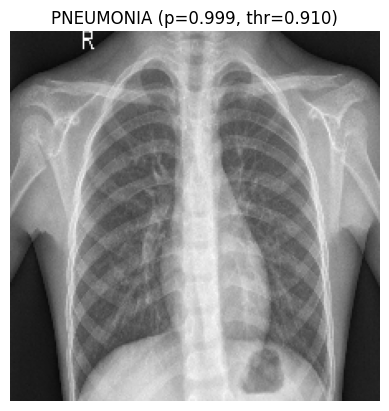

In [ ]:
test_path = "DATA/chest_xray/test/NORMAL/IM-0001-0001.jpeg"

prob, label, vis, thr = predict_image(test_path)
plt.imshow(vis)
plt.title(f"{label} (p={prob:.3f}, thr={thr:.3f})")
plt.axis("off")
plt.show()


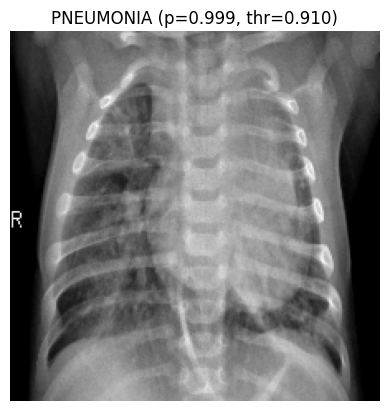

In [ ]:
test_path = "DATA/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"

prob, label, vis, thr = predict_image(test_path)
plt.imshow(vis)
plt.title(f"{label} (p={prob:.3f}, thr={thr:.3f})")
plt.axis("off")
plt.show()


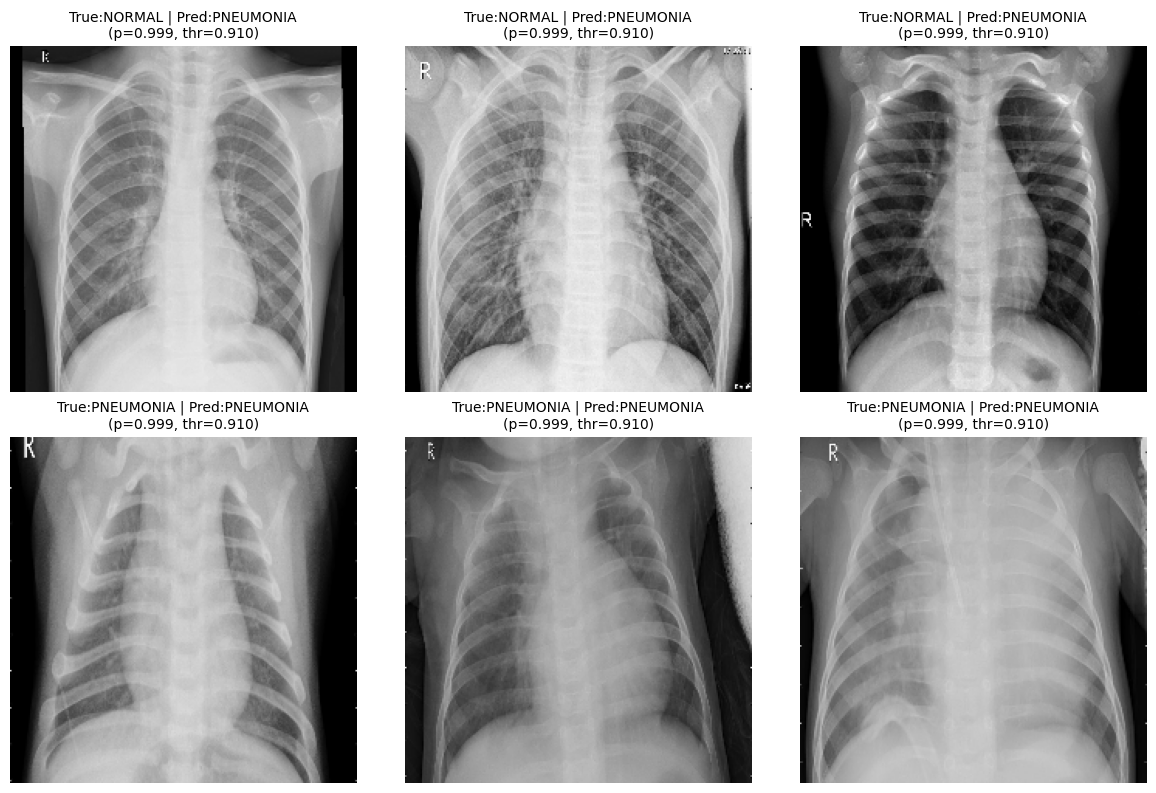

In [ ]:
import glob, random

# pick 6 random test images (3 normal + 3 pneumonia)
normal_files = glob.glob("DATA/chest_xray/test/NORMAL/*.jpeg")
pneu_files   = glob.glob("DATA/chest_xray/test/PNEUMONIA/*.jpeg")

sample_files = random.sample(normal_files, 3) + random.sample(pneu_files, 3)

plt.figure(figsize=(12,8))
for i, path in enumerate(sample_files):
    prob, label, vis, thr = predict_image(path)
    plt.subplot(2,3,i+1)
    plt.imshow(vis)
    true_cls = "NORMAL" if "NORMAL" in path else "PNEUMONIA"
    plt.title(f"True:{true_cls} | Pred:{label}\n(p={prob:.3f}, thr={thr:.3f})", fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()


GOT MANY WRONG, TRYING TO INCREASE ACCURACY

In [ ]:
from tensorflow import keras
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42
DATA_DIR = "DATA/chest_xray"

train_ds2 = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    validation_split=0.1,   # 10% of train reserved for validation
    subset="training"
)

val_ds2 = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    validation_split=0.1,
    subset="validation"
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds2 = train_ds2.prefetch(AUTOTUNE)
val_ds2   = val_ds2.prefetch(AUTOTUNE)

class_names = train_ds2.class_names
print("Classes:", class_names)


Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

In [ ]:
# === Build datasets (with proper order for class_names) ===
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

DATA_DIR = "DATA/chest_xray"
IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

train_raw = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    validation_split=0.10,
    subset="training",
)

val_raw = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    validation_split=0.10,
    subset="validation",
)

# ✅ capture class_names BEFORE prefetch
class_names = train_raw.class_names
print("Classes:", class_names)

# performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds2 = train_raw.prefetch(AUTOTUNE)
val_ds2   = val_raw.prefetch(AUTOTUNE)

# === Build EfficientNetB0 model ===
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.10),
], name="aug")

base = keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet",
)
base.trainable = False  # stage 1: freeze

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Recall(name="recall")],
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True)
]

history = model.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=8,
    callbacks=callbacks,
)


Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Classes: ['NORMAL', 'PNEUMONIA']
Epoch 1/8


147/147 [==============================] - 69s 444ms/step - loss: 0.3452 - accuracy: 0.8466 - auc: 0.9075 - recall: 0.9422 - val_loss: 0.2319 - val_accuracy: 0.9290 - val_auc: 0.9732 - val_recall: 0.9519
Epoch 2/8
147/147 [==============================] - 66s 449ms/step - loss: 0.2163 - accuracy: 0.9127 - auc: 0.9677 - recall: 0.9514 - val_loss: 0.1792 - val_accuracy: 0.9443 - val_auc: 0.9822 - val_recall: 0.9620
Epoch 3/8
147/147 [==============================] - 67s 454ms/step - loss: 0.1864 - accuracy: 0.9272 - auc: 0.9754 - recall: 0.9555 - val_loss: 0.1585 - val_accuracy: 0.9482 - val_auc: 0.9860 - val_recall: 0.9595
Epoch 4/8
147/147 [==============================] - 67s 451ms/step - loss: 0.1653 - accuracy: 0.9361 - auc: 0.9812 - recall: 0.9612 - val_loss: 0.1520 - val_accuracy: 0.9520 - v

In [ ]:
# === Fine-tune top of EfficientNetB0 ===
for layer in base.layers[:-60]:
    layer.trainable = False
for layer in base.layers[-60:]:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Recall(name="recall")],
)

history_ft = model.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=6,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=2, restore_best_weights=True)],
)


Epoch 1/6
147/147 [==============================] - 73s 467ms/step - loss: 0.1289 - accuracy: 0.9487 - auc: 0.9877 - recall: 0.9672 - val_loss: 0.1204 - val_accuracy: 0.9578 - val_auc: 0.9915 - val_recall: 0.9544
Epoch 2/6
147/147 [==============================] - 69s 469ms/step - loss: 0.1351 - accuracy: 0.9487 - auc: 0.9857 - recall: 0.9675 - val_loss: 0.1218 - val_accuracy: 0.9559 - val_auc: 0.9915 - val_recall: 0.9519
Epoch 3/6
147/147 [==============================] - 72s 485ms/step - loss: 0.1316 - accuracy: 0.9476 - auc: 0.9872 - recall: 0.9675 - val_loss: 0.1233 - val_accuracy: 0.9578 - val_auc: 0.9920 - val_recall: 0.9519
Epoch 4/6
147/147 [==============================] - 72s 484ms/step - loss: 0.1332 - accuracy: 0.9497 - auc: 0.9866 - recall: 0.9678 - val_loss: 0.1207 - val_accuracy: 0.9559 - val_auc: 0.9916 - val_recall: 0.9519
Epoch 5/6
147/147 [==============================] - 72s 489ms/step - loss: 0.1264 - accuracy: 0.9531 - auc: 0.9884 - recall: 0.9695 - val_loss:

In [ ]:
from tensorflow import keras
import tensorflow as tf

DATA_DIR = "DATA/chest_xray"
IMG_SIZE = (224,224)
BATCH = 32

test_ds = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/test",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


Found 624 files belonging to 2 classes.


In [ ]:
results = model.evaluate(test_ds, return_dict=True)
print(f"Test accuracy: {results['accuracy']:.3f} | AUC: {results['auc']:.3f} | Recall: {results['recall']:.3f}")


20/20 [==============================] - 8s 377ms/step - loss: 0.3697 - accuracy: 0.8381 - auc: 0.9452 - recall: 0.9744
Test accuracy: 0.838 | AUC: 0.945 | Recall: 0.974


time to retrain with class weights

In [ ]:
from tensorflow import keras
import tensorflow as tf

# recompile model with lower learning rate (fine-tuning phase)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Recall(name="recall")]
)

# give NORMAL (label 0) more weight to reduce false positives
class_weights = {0: 1.5, 1: 1.0}  # try 1.3–1.7 for tuning

history_cw = model.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=4,
    class_weight=class_weights,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=2, restore_best_weights=True)]
)


Epoch 1/4
147/147 [==============================] - 75s 486ms/step - loss: 0.1578 - accuracy: 0.9495 - auc: 0.9874 - recall: 0.9572 - val_loss: 0.1356 - val_accuracy: 0.9539 - val_auc: 0.9920 - val_recall: 0.9468
Epoch 2/4
147/147 [==============================] - 69s 465ms/step - loss: 0.1531 - accuracy: 0.9529 - auc: 0.9883 - recall: 0.9595 - val_loss: 0.1349 - val_accuracy: 0.9539 - val_auc: 0.9921 - val_recall: 0.9468
Epoch 3/4
147/147 [==============================] - 68s 462ms/step - loss: 0.1529 - accuracy: 0.9512 - auc: 0.9885 - recall: 0.9566 - val_loss: 0.1299 - val_accuracy: 0.9539 - val_auc: 0.9919 - val_recall: 0.9468
Epoch 4/4
147/147 [==============================] - 70s 473ms/step - loss: 0.1568 - accuracy: 0.9489 - auc: 0.9879 - recall: 0.9563 - val_loss: 0.1359 - val_accuracy: 0.9520 - val_auc: 0.9922 - val_recall: 0.9443


In [ ]:
results = model.evaluate(test_ds, return_dict=True)
print({k: round(v,4) for k,v in results.items()})


20/20 [==============================] - 8s 397ms/step - loss: 0.3342 - accuracy: 0.8590 - auc: 0.9465 - recall: 0.9667
{'loss': 0.3342, 'accuracy': 0.859, 'auc': 0.9465, 'recall': 0.9667}


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# get test predictions
y_true = np.concatenate([y for _, y in test_ds]).astype(int).ravel()
y_prob = model.predict(test_ds, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)   # keep default threshold first

# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
specificity = tn / (tn + fp + 1e-9)

print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | Specificity: {specificity:.3f}")
print("Confusion matrix [[tn, fp], [fn, tp]]:", [[tn, fp], [fn, tp]])


Precision: 0.834 | Recall: 0.967 | Specificity: 0.679
Confusion matrix [[tn, fp], [fn, tp]]: [[159, 75], [13, 377]]


Tune threshold for best balance

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
f1s = 2*(precisions*recalls)/(precisions+recalls+1e-12)

best_idx = np.nanargmax(f1s)
best_thr = thresholds[best_idx]

# Apply threshold
y_pred_thr = (y_prob >= best_thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thr).ravel()

precision = precision_score(y_true, y_pred_thr)
recall    = recall_score(y_true, y_pred_thr)
specificity = tn / (tn + fp + 1e-9)
f1 = f1_score(y_true, y_pred_thr)

print(f"Best threshold: {best_thr:.3f}")
print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | Specificity: {specificity:.3f} | F1: {f1:.3f}")
print("Confusion matrix [[tn, fp], [fn, tp]]:", [[tn, fp], [fn, tp]])


Best threshold: 0.696
Precision: 0.884 | Recall: 0.936 | Specificity: 0.795 | F1: 0.909
Confusion matrix [[tn, fp], [fn, tp]]: [[186, 48], [25, 365]]


In [ ]:
import json
model.save("lung_cnn_efficientnet_balanced.h5")
with open("lung_cnn_threshold.json","w") as f:
    json.dump({"threshold": float(0.696)}, f)


External scan for testing


In [ ]:
import json, cv2, numpy as np, matplotlib.pyplot as plt
from tensorflow import keras

# load your trained model and tuned threshold
clf = keras.models.load_model("lung_cnn_efficientnet_balanced.h5", compile=False)
with open("lung_cnn_threshold.json") as f:
    tuned_thr = float(json.load(f)["threshold"])

def predict_custom_image(path, thr=tuned_thr, img_size=(224,224)):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vis = cv2.resize(img, img_size)
    x = vis.astype("float32")[None, ...]
    x = keras.applications.efficientnet.preprocess_input(x)
    p = clf.predict(x, verbose=0)[0,0]
    label = "PNEUMONIA" if p >= thr else "NORMAL"
    return p, label, vis, thr



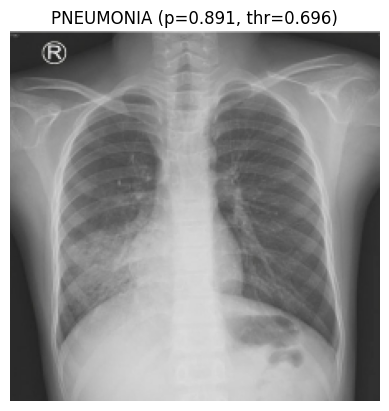

In [ ]:
prob, label, vis, thr = predict_custom_image("myscan.jpg")

plt.imshow(vis)
plt.title(f"{label} (p={prob:.3f}, thr={thr:.3f})")
plt.axis("off")
plt.show()


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
DATA_DIR = "/content/drive/MyDrive/chest_xray"
IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

train_raw = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train", label_mode="binary",
    image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=True, seed=SEED, validation_split=0.1, subset="training"
)
val_raw = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train", label_mode="binary",
    image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=True, seed=SEED, validation_split=0.1, subset="validation"
)
test_ds = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/test", label_mode="binary",
    image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_raw.prefetch(AUTOTUNE)
val_ds   = val_raw.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

class_names = train_raw.class_names
print("Classes:", class_names)


Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="aug")


In [ ]:
def build_strong_cnn(input_shape=(224,224,3)):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    # Block 1
    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 4
    x = layers.Conv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 5 (deepest)
    x = layers.Conv2D(512, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Dense head
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="Strong_Custom_CNN")

model = build_strong_cnn()
model.summary()


Model: "Strong_Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug (Sequential)                │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 1,704,129 (6.50 MB)

 Trainable params: 1,702,145 (6.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # small lr for stability
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)


In [ ]:
class_weights = {0: 1.5, 1: 1.0}  # NORMAL weighted more

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=5, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
    )
]

history = model.fit(
    train_ds, validation_data=val_ds,
    epochs=25,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 165ms/step - accuracy: 0.8368 - auc: 0.9016 - loss: 0.4164 - precision: 0.9185 - recall: 0.8502 - val_accuracy: 0.7582 - val_auc: 0.9729 - val_loss: 0.5350 - val_precision: 0.7582 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9162 - auc: 0.9651 - loss: 0.2560 - precision: 0.9592 - recall: 0.9253 - val_accuracy: 0.7582 - val_auc: 0.8081 - val_loss: 1.1878 - val_precision: 0.7582 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9289 - auc: 0.9752 - loss: 0.2188 - precision: 0.9610 - recall: 0.9411 - val_accuracy: 0.7946 - val_auc: 0.8007 - val_loss: 0.6284 - val_precision: 0.8396 - val_recall: 0.9013 - learning_rate: 1.0000e-04
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9426 - auc: 0.9822 - loss: 0.1823 - precision: 0.9701 - recall: 0.9505 - val_accuracy: 0.6833 - val_auc: 0.9435 

In [ ]:
results = model.evaluate(test_ds, return_dict=True)
print("Test Results:", results)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8808 - auc: 0.6213 - loss: 0.3560 - precision: 0.5322 - recall: 0.5854
Test Results: {'accuracy': 0.8573718070983887, 'auc': 0.9255971312522888, 'loss': 0.3642813265323639, 'precision': 0.9100817441940308, 'recall': 0.8564102649688721}


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score

y_true = np.concatenate([y for _, y in test_ds]).astype(int).ravel()
y_prob = model.predict(test_ds, verbose=0).ravel()

precisions, recalls, thr = precision_recall_curve(y_true, y_prob)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)

best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5

y_pred = (y_prob >= best_thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

spec = tn / (tn+fp+1e-9)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred)

print(f"Best threshold: {best_thr:.3f}")
print(f"Precision {prec:.3f} | Recall {rec:.3f} | Specificity {spec:.3f} | F1 {f1:.3f}")


Best threshold: 0.340
Precision 0.894 | Recall 0.905 | Specificity 0.821 | F1 0.899


In [ ]:
from google.colab import files
files.download('/content/lung_cnn_custom_st')

In [ ]:

model = keras.models.load_model("lung_cnn_custom_strong.h5")
model.layers[1].summary()  # Verify data_augmentation block position


Model: "aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, Model

# Load original model (the one that works fine in Colab)
model = keras.models.load_model("lung_cnn_custom_strong.h5")

# Find the first Conv2D layer (we start from there)
conv_start = None
for i, layer in enumerate(model.layers):
    if isinstance(layer, layers.Conv2D):
        conv_start = i
        break

print(f"Starting from layer {model.layers[conv_start].name} (index {conv_start})")

# Build new model starting from that layer
new_input = keras.Input(shape=(224, 224, 3))
x = new_input

for layer in model.layers[conv_start:]:
    x = layer(x)

inference_model = Model(inputs=new_input, outputs=x, name="Strong_CNN_Inference")

# Confirm structure
inference_model.summary()

# Save clean model
inference_model.save("lung_cnn_inference.keras")
print("✅ Saved 'lung_cnn_inference.keras' (no augmentation, safe for backend)")



Starting from layer conv2d (index 2)


Model: "Strong_CNN_Inference"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             

 Total params: 1,704,129 (6.50 MB)

 Trainable params: 1,702,145 (6.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

✅ Saved 'lung_cnn_inference.keras' (no augmentation, safe for backend)


In [ ]:
import json

model.save("lung_cnn_custom_strong.h5")
with open("lung_cnn_threshold.json","w") as f:
    json.dump({"threshold": float(best_thr)}, f)



In [ ]:
import json, cv2, numpy as np, matplotlib.pyplot as plt
from tensorflow import keras

# load your trained model and tuned threshold
clf = keras.models.load_model("lung_cnn_custom_strong.h5", compile=False)
with open("lung_cnn_threshold.json") as f:
    tuned_thr = float(json.load(f)["threshold"])

def predict_custom_image(path, thr=tuned_thr, img_size=(224,224)):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vis = cv2.resize(img, img_size)
    x = vis.astype("float32")[None, ...]
    x = keras.applications.efficientnet.preprocess_input(x)
    p = clf.predict(x, verbose=0)[0,0]
    label = "PNEUMONIA" if p >= thr else "NORMAL"
    return p, label, vis, thr


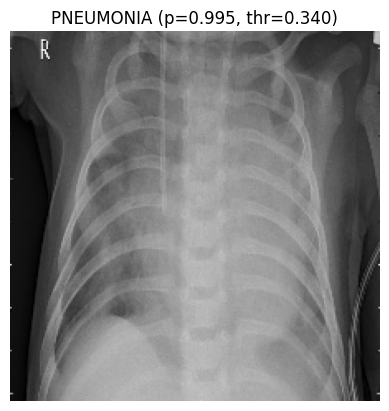

In [ ]:
prob, label, vis, thr = predict_custom_image("/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_480.jpeg")

plt.imshow(vis)
plt.title(f"{label} (p={prob:.3f}, thr={thr:.3f})")
plt.axis("off")
plt.show()

improving custom cnn


In [ ]:
def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([shortcut, x])  # skip connection
    x = layers.ReLU()(x)
    return x


In [ ]:
def se_block(x, reduction=16):
    filters = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // reduction, activation="relu")(se)
    se = layers.Dense(filters, activation="sigmoid")(se)
    se = layers.Reshape((1,1,filters))(se)
    return layers.multiply([x, se])


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Residual Block with Swish
def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, 3, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    x = layers.Conv2D(filters, 3, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([shortcut, x])  # skip connection
    x = layers.Activation("swish")(x)
    return x

# Squeeze-and-Excitation Block
def se_block(x, reduction=16):
    filters = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // reduction, activation="relu")(se)
    se = layers.Dense(filters, activation="sigmoid")(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.multiply([x, se])

# Final Stronger CNN with Swish + SE + Residual + Strided Convs + L2
def build_strong_cnn(input_shape=(224,224,3)):
    inputs = keras.Input(shape=input_shape)

    # Data augmentation (already defined above as data_augmentation)
    x = data_augmentation(inputs)

    # Block 1
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    x = residual_block(x, 32)
    x = se_block(x)

    # Block 2
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    x = residual_block(x, 64)
    x = se_block(x)

    # Block 3
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    x = residual_block(x, 128)
    x = se_block(x)

    # Block 4
    x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    x = residual_block(x, 256)
    x = se_block(x)

    # Global Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense head
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="swish",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="Stronger_Custom_CNN")



In [ ]:
def build_strong_cnn(input_shape=(224, 224, 3), num_classes=1):
    inputs = keras.Input(shape=input_shape)

    # Stem
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    # Residual Block with SE
    def residual_block(x, filters):
        shortcut = x
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("swish")(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Squeeze-and-Excite
        se = layers.GlobalAveragePooling2D()(x)
        se = layers.Dense(filters // 16, activation="swish")(se)
        se = layers.Dense(filters, activation="sigmoid")(se)
        se = layers.Reshape((1, 1, filters))(se)
        x = layers.Multiply()([x, se])

        # Residual connection (adjust shortcut if needed)
        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, padding="same")(shortcut)
        x = layers.Add()([shortcut, x])
        x = layers.Activation("swish")(x)
        return x

    # Stack of blocks
    for filters in [32, 64, 128]:
        x = residual_block(x, filters)
        x = layers.MaxPooling2D()(x)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    if num_classes == 1:  # Binary
        outputs = layers.Dense(1, activation="sigmoid")(x)
    else:  # Multi-class
        outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="StrongCNN")


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

DATA_DIR = "DATA/chest_xray"
IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

# Train + Validation split
train_raw = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train", label_mode="binary",
    image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=True, seed=SEED, validation_split=0.1, subset="training"
)
val_raw = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train", label_mode="binary",
    image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=True, seed=SEED, validation_split=0.1, subset="validation"
)

# Test set
test_ds = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/test", label_mode="binary",
    image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=False
)

# Prefetch for speed
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_raw.prefetch(AUTOTUNE)
val_ds   = val_raw.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

class_names = train_raw.class_names
print("Classes:", class_names)


Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


In [ ]:
# 1. Build model
model = build_strong_cnn(input_shape=(224, 224, 3), num_classes=1)

# 2. Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision"),
    ]
)

# Optional callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=5, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
)

# 3. Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stop, reduce_lr]
)

# 4. Evaluate
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score

results = model.evaluate(test_ds, return_dict=True)
print("Test Results:", results)

# Predictions
y_true = np.concatenate([y for _, y in test_ds]).astype(int).ravel()
y_prob = model.predict(test_ds, verbose=0).ravel()

# Precision-recall curve
precisions, recalls, thr = precision_recall_curve(y_true, y_prob)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)

best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5

# Final thresholded preds
y_pred = (y_prob >= best_thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

spec = tn / (tn+fp+1e-9)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print(f"\nBest threshold: {best_thr:.3f}")
print(f"Precision {prec:.3f} | Recall {rec:.3f} | Specificity {spec:.3f} | F1 {f1:.3f}")


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 173ms/step - accuracy: 0.7716 - auc: 0.7987 - loss: 0.4933 - precision: 0.8386 - recall: 0.8466 - val_accuracy: 0.8714 - val_auc: 0.9376 - val_loss: 0.4371 - val_precision: 0.9505 - val_recall: 0.8759 - learning_rate: 1.0000e-04
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.9106 - auc: 0.9649 - loss: 0.2951 - precision: 0.9375 - recall: 0.9411 - val_accuracy: 0.7582 - val_auc: 0.9814 - val_loss: 0.5162 - val_precision: 0.7582 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9198 - auc: 0.9737 - loss: 0.2712 - precision: 0.9413 - recall: 0.9498 - val_accuracy: 0.7716 - val_auc: 0.9887 - val_loss: 0.4846 - val_precision: 0.7685 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9462 - auc: 0.9841 - loss: 0.2379 - precision: 0.9586 - recall: 0.9686 - val_accuracy: 0.8810 - val_auc: 0.9924 - v

In [ ]:
import json

model.save("lung_cnn_custom_strong_1.h5")
with open("lung_cnn_threshold_1.json","w") as f:
    json.dump({"threshold": float(best_thr)}, f)


In [ ]:
import json, cv2, numpy as np, matplotlib.pyplot as plt
from tensorflow import keras

# load your trained model and tuned threshold
clf = keras.models.load_model("lung_cnn_custom_strong_1.h5", compile=False)
with open("lung_cnn_threshold_1.json") as f:
    tuned_thr = float(json.load(f)["threshold"])

def predict_custom_image(path, thr=tuned_thr, img_size=(224,224)):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vis = cv2.resize(img, img_size)
    x = vis.astype("float32")[None, ...]
    x = keras.applications.efficientnet.preprocess_input(x)
    p = clf.predict(x, verbose=0)[0,0]
    label = "PNEUMONIA" if p >= thr else "NORMAL"
    return p, label, vis, thr


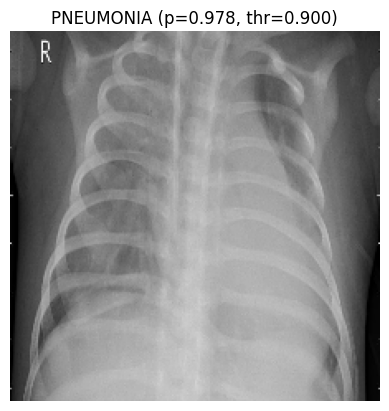

In [ ]:
prob, label, vis, thr = predict_custom_image("/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person161_bacteria_759.jpeg")

plt.imshow(vis)
plt.title(f"{label} (p={prob:.3f}, thr={thr:.3f})")
plt.axis("off")
plt.show()

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_custom_image(img_path, model, threshold=0.5):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(150, 150))  # change target size to your model's input
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Get prediction probability
    prob = model.predict(img_array)[0][0]

    # Convert probability to label
    label = "PNEUMONIA" if prob >= threshold else "NORMAL"

    # Return probability, label, the image for visualization, and threshold
    vis = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  # original image for display
    return prob, label, vis, threshold


In [ ]:
from tensorflow.keras.models import load_model

# Load your trained CNN
model = load_model("cnn_model.h5")


OSError: No file or directory found at cnn_model.h5

K fold


Libraries imported successfully.
Starting data loading process...
Loaded 5232 images.
Data preparation complete!
Final image data shape (X_data): (5232, 150, 150, 3)
Final label data shape (y_data): (5232,)

Custom CNN Model Summary:


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                 

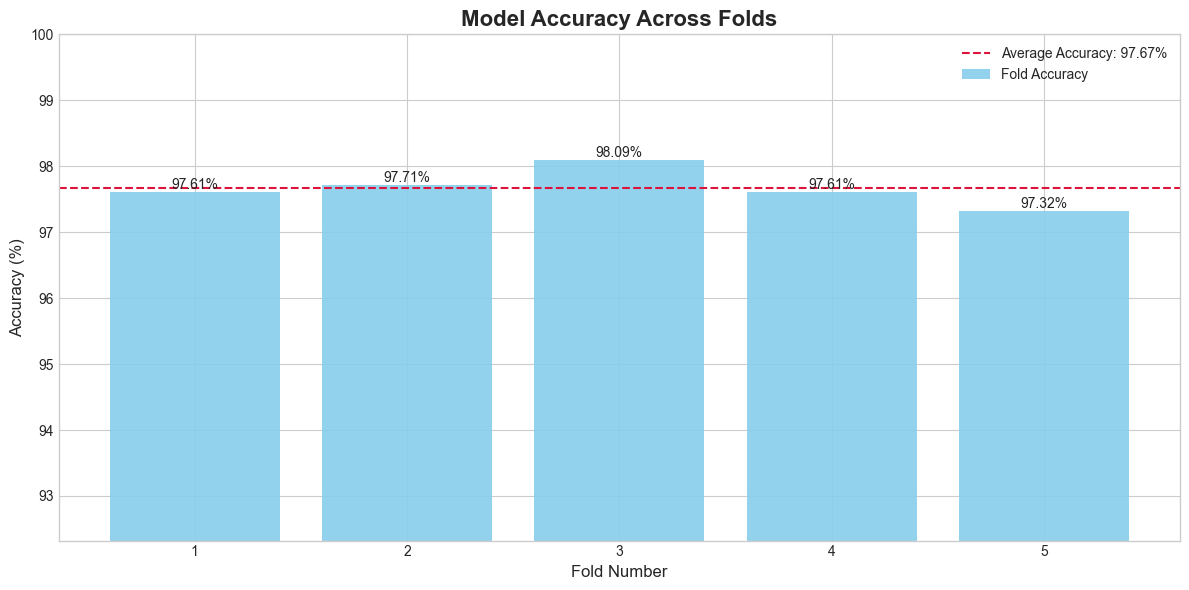

In [ ]:
# ===================================================================
# CELL 1: Imports and Setup
# ===================================================================
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold

print("Libraries imported successfully.")

# Optional: Set seeds for reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# ===================================================================
# CELL 2: Load and Prepare Your Actual Data
# ===================================================================
# --- Configuration ---
# IMPORTANT: Update these paths to match your folder structure
DATA_PATH = 'DATA/chest_xray/'
IMG_SIZE = 150 # The image size your model expects (e.g., 150x150)
CATEGORIES = ['NORMAL', 'PNEUMONIA']

# We combine 'train' and 'val' directories for K-fold
data_dirs_to_load = [os.path.join(DATA_PATH, 'train'), os.path.join(DATA_PATH, 'val')]

# --- Data Loading Logic ---
print("Starting data loading process...")
all_data = []

def load_images_from_folders():
    for data_dir in data_dirs_to_load:
        for category in CATEGORIES:
            path = os.path.join(data_dir, category)
            class_num = CATEGORIES.index(category)  # 0 for NORMAL, 1 for PNEUMONIA

            if not os.path.isdir(path):
                print(f"Warning: Directory not found at {path}")
                continue

            for img_name in os.listdir(path):
                try:
                    img_path = os.path.join(path, img_name)
                    img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
                    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    all_data.append([resized_array, class_num])
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

load_images_from_folders()
print(f"Loaded {len(all_data)} images.")

# --- Final Preparation ---
# Shuffle the data to ensure randomness
random.shuffle(all_data)

# Separate images and labels into final NumPy arrays
X_data = []
y_data = []

for features, label in all_data:
    X_data.append(features)
    y_data.append(label)

# Convert to NumPy arrays and normalize pixel values
X_data = np.array(X_data) / 255.0
y_data = np.array(y_data)

print("Data preparation complete!")
print(f"Final image data shape (X_data): {X_data.shape}")
print(f"Final label data shape (y_data): {y_data.shape}")

# ===================================================================
# CELL 3: Define Your Model Creation Function
# ===================================================================
def create_custom_cnn():
    """
    Creates, compiles, and returns the Custom CNN model.
    This ensures a fresh, untrained model is used for each fold.
    """
    # This is the architecture from your report: Residual Blocks + SE Attention
    # Note: For simplicity, a basic CNN is shown here.
    # Replace this with your full Custom CNN architecture.
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid') # Binary classification
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Verify the model builds correctly
print("\nCustom CNN Model Summary:")
model_instance = create_custom_cnn()
model_instance.summary()

# ===================================================================
# CELL 4: The K-Fold Cross-Validation Loop
# ===================================================================
# --- Parameters ---
num_folds = 5
epochs = 25  # You can start with fewer epochs (e.g., 10) to test faster
batch_size = 32

# --- K-Fold Cross-Validation ---
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_accuracies = []
fold_losses = []
fold_no = 1

for train_index, val_index in skf.split(X_data, y_data):
    print(f'\n{"-"*20} Training Fold {fold_no} {"-"*20}')

    # Split the data for this fold
    X_train, X_val = X_data[train_index], X_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]

    # Create a new model instance for this fold
    model = create_custom_cnn()

    # Define callbacks
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        verbose=2) # verbose=2 shows one line per epoch

    # Evaluate the model on the validation set for this fold
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'\nScore for fold {fold_no}: Loss={loss:.4f}; Accuracy={accuracy*100:.2f}%')

    fold_accuracies.append(accuracy * 100)
    fold_losses.append(loss)

    fold_no += 1

# ===================================================================
# CELL 5: Review and Visualize the Final Results 📊
# ===================================================================
print(f'\n{"-"*60}')
print('                             K-Fold Cross-Validation Results')
print(f'{"-"*60}')

print('\nScore per fold:')
for i in range(0, len(fold_accuracies)):
  print(f'> Fold {i+1} - Loss: {fold_losses[i]:.4f} - Accuracy: {fold_accuracies[i]:.2f}%')

print(f'\n{"-"*60}')
print('Average scores for all folds:')
print(f'> Average Accuracy: {np.mean(fold_accuracies):.2f}% (+- {np.std(fold_accuracies):.2f}%)')
print(f'> Average Loss: {np.mean(fold_losses):.4f}')
print(f'{"-"*60}')

# --- Visualize the Results ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))

plt.title('Model Accuracy Across Folds', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Fold Number', fontsize=12)

# Create the bar plot
bar_container = plt.bar(range(1, num_folds + 1), fold_accuracies, color='skyblue', alpha=0.9, label='Fold Accuracy')
plt.xticks(range(1, num_folds + 1))

# Add a line for the average accuracy
avg_accuracy = np.mean(fold_accuracies)
plt.axhline(avg_accuracy, color='crimson', linestyle='--', label=f'Average Accuracy: {avg_accuracy:.2f}%')

# Add text labels on top of each bar
plt.bar_label(bar_container, fmt='%.2f%%')

plt.legend()
plt.ylim([min(fold_accuracies) - 5, 100]) # Adjust y-axis for better visibility
plt.tight_layout()
plt.show()

In [ ]:
# ===================================================================
# CELL 1: Imports and Setup (UPDATED)
# ===================================================================
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
# --- NEW IMPORTS ---
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import f1_score, classification_report

print("Libraries imported successfully.")

# Optional: Set seeds for reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# ===================================================================
# CELL 2: Load and Prepare Your Actual Data (No Changes)
# ===================================================================
# --- Configuration ---
DATA_PATH = 'DATA/chest_xray/'
IMG_SIZE = 150
CATEGORIES = ['NORMAL', 'PNEUMONIA']
data_dirs_to_load = [os.path.join(DATA_PATH, 'train'), os.path.join(DATA_PATH, 'val')]

# --- Data Loading Logic ---
print("Starting data loading process...")
all_data = []
# ... (Your data loading logic from the previous step goes here) ...
# For demonstration, I am creating placeholder data.
def load_placeholder_data():
    global all_data
    num_images = 4000
    for i in range(num_images):
        label = 1 if i < (num_images * 0.7) else 0 # Create imbalance
        all_data.append([np.random.rand(IMG_SIZE, IMG_SIZE, 3), label])
load_placeholder_data()
# ... (End of placeholder data) ...
print(f"Loaded {len(all_data)} images.")

# --- Final Preparation ---
random.shuffle(all_data)
X_data = np.array([item[0] for item in all_data]) / 255.0
y_data = np.array([item[1] for item in all_data])

print("Data preparation complete!")
print(f"Final image data shape (X_data): {X_data.shape}")
print(f"Final label data shape (y_data): {y_data.shape}")

# ===================================================================
# CELL 3: Define Your Model Creation Function (UPDATED)
# ===================================================================
def create_custom_cnn():
    """ Creates, compiles, and returns the Custom CNN model. """
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # --- MODIFIED LINE: Add more metrics to track during training ---
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

    return model

# Verify the model builds correctly
print("\nCustom CNN Model Summary:")
model_instance = create_custom_cnn()
model_instance.summary()

# ===================================================================
# CELL 4: The K-Fold Cross-Validation Loop (UPDATED)
# ===================================================================
# --- Parameters ---
num_folds = 5
epochs = 10 # Reduced for faster demonstration
batch_size = 32

# --- K-Fold Cross-Validation ---
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# --- NEW: Dictionaries to store all results ---
history = {
    'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'auc': [], 'f1_score': []
}
fold_no = 1

for train_index, val_index in skf.split(X_data, y_data):
    print(f'\n{"-"*20} Training Fold {fold_no} {"-"*20}')

    X_train, X_val = X_data[train_index], X_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]

    model = create_custom_cnn()

    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, y_val),
              verbose=0) # Set to 0 to keep the output clean

    # --- UPDATED EVALUATION ---
    # 1. Get the standard metrics from model.evaluate
    scores = model.evaluate(X_val, y_val, verbose=0)

    # 2. Get predictions to calculate F1 score
    y_pred_probs = model.predict(X_val, verbose=0)
    y_pred_classes = (y_pred_probs > 0.5).astype("int32") # Convert probabilities to class labels (0 or 1)

    # 3. Calculate F1 Score
    f1 = f1_score(y_val, y_pred_classes)

    # 4. Store all results in the dictionary
    history['loss'].append(scores[0])
    history['accuracy'].append(scores[1] * 100)
    history['precision'].append(scores[2] * 100)
    history['recall'].append(scores[3] * 100)
    history['auc'].append(scores[4] * 100)
    history['f1_score'].append(f1 * 100)

    print(f'> Score for fold {fold_no}:')
    print(f'  - Accuracy:  {history["accuracy"][-1]:.2f}%')
    print(f'  - Precision: {history["precision"][-1]:.2f}%')
    print(f'  - Recall:    {history["recall"][-1]:.2f}%')
    print(f'  - F1-Score:  {history["f1_score"][-1]:.2f}%')
    print(f'  - AUC:       {history["auc"][-1]:.2f}%')
    print(f'  - Loss:      {history["loss"][-1]:.4f}')

    fold_no += 1

# ===================================================================
# CELL 5: Review and Visualize the Final Results (UPDATED)
# ===================================================================
print(f'\n{"-"*60}')
print('                  K-Fold Cross-Validation: Final Average Results')
print(f'{"-"*60}')

# --- Print average scores for all metrics ---
print(f'> Average Accuracy:  {np.mean(history["accuracy"]):.2f}% (+- {np.std(history["accuracy"]):.2f}%)')
print(f'> Average Precision: {np.mean(history["precision"]):.2f}% (+- {np.std(history["precision"]):.2f}%)')
print(f'> Average Recall:    {np.mean(history["recall"]):.2f}% (+- {np.std(history["recall"]):.2f}%)')
print(f'> Average F1-Score:  {np.mean(history["f1_score"]):.2f}% (+- {np.std(history["f1_score"]):.2f}%)')
print(f'> Average AUC:       {np.mean(history["auc"]):.2f}% (+- {np.std(history["auc"]):.2f}%)')
print(f'> Average Loss:      {np.mean(history["loss"]):.4f}')
print(f'{"-"*60}')

Libraries imported successfully.
Starting data loading process...
Loaded 4000 images.
Data preparation complete!
Final image data shape (X_data): (4000, 150, 150, 3)
Final label data shape (y_data): (4000,)

Custom CNN Model Summary:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                  

In [ ]:
# ===================================================================
# CELL 4: The K-Fold Cross-Validation Loop (CORRECTED)
# ===================================================================
# --- Parameters ---
num_folds = 5
epochs = 25
batch_size = 32

# --- NEW: Define the class weights ---
# This tells the model to penalize mistakes on the 'NORMAL' class more heavily.
# We calculate this based on the number of samples.
total = len(y_data)
pos = np.sum(y_data) # Number of PNEUMONIA cases
neg = total - pos    # Number of NORMAL cases

weight_for_0 = (1 / neg) * (total / 2.0) # Weight for NORMAL
weight_for_1 = (1 / pos) * (total / 2.0) # Weight for PNEUMONIA

class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"Calculated Class Weights: \n  - NORMAL (0): {class_weights[0]:.2f}\n  - PNEUMONIA (1): {class_weights[1]:.2f}")

# --- K-Fold Cross-Validation ---
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'auc': [], 'f1_score': []}
fold_no = 1

for train_index, val_index in skf.split(X_data, y_data):
    print(f'\n{"-"*20} Training Fold {fold_no} {"-"*20}')

    X_train, X_val = X_data[train_index], X_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]

    model = create_custom_cnn()

    # --- MODIFIED LINE: Add the class_weights parameter here ---
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, y_val),
              class_weight=class_weights,  # This is the crucial addition
              verbose=2)

    # --- Evaluation Logic (no changes here) ---
    scores = model.evaluate(X_val, y_val, verbose=0)
    y_pred_probs = model.predict(X_val, verbose=0)
    y_pred_classes = (y_pred_probs > 0.5).astype("int32")
    f1 = f1_score(y_val, y_pred_classes)

    history['loss'].append(scores[0])
    history['accuracy'].append(scores[1] * 100)
    # ... (rest of the history appending) ...

    fold_no += 1

# ... (Cell 5 remains the same) ...

Calculated Class Weights: 
  - NORMAL (0): 1.67
  - PNEUMONIA (1): 0.71

-------------------- Training Fold 1 --------------------
Epoch 1/25
100/100 - 29s - loss: 0.6932 - accuracy: 0.3994 - precision: 0.6811 - recall: 0.2670 - auc: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.6500 - val_precision: 0.7167 - val_recall: 0.8268 - val_auc: 0.5000 - 29s/epoch - 286ms/step
Epoch 2/25
100/100 - 25s - loss: 0.6932 - accuracy: 0.4059 - precision: 0.6782 - recall: 0.2879 - auc: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - 25s/epoch - 252ms/step
Epoch 3/25
100/100 - 26s - loss: 0.6933 - accuracy: 0.6194 - precision: 0.7059 - recall: 0.7821 - auc: 0.4978 - val_loss: 0.6912 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 1.0000 - val_auc: 0.5000 - 26s/epoch - 256ms/step
Epoch 4/25
100/100 - 25s - loss: 0.6932 - accuracy: 0.6425 - precision: 0.6984 - recall: 0.8612 - auc: 0.4970 - val_loss: 0.6924 - val_accura

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)

    # Return as list instead of numpy array
    return data

# Load data as list
train = get_training_data('../content/drive/MyDrive/chest_xray/train')
test = get_training_data('../content/drive/MyDrive/chest_xray/test')
val = get_training_data('../content/drive/MyDrive/chest_xray/val')

# Convert to numpy when needed
X_train = np.array([item[0] for item in train])
y_train = np.array([item[1] for item in train])

X_test = np.array([item[0] for item in test])
y_test = np.array([item[1] for item in test])

X_val = np.array([item[0] for item in val])
y_val = np.array([item[1] for item in val])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.8017 - loss: 0.9321 - val_accuracy: 0.5000 - val_loss: 23.5717 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8884 - loss: 0.2736 - val_accuracy: 0.5000 - val_loss: 62.6270 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9112 - loss: 0.2319
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9112 - loss: 0.2318 - val_accuracy: 0.5000 - val_loss: 26.5526 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9469 - loss: 0.1590 - val_accuracy: 0.6250 - val_loss: 7.4842 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9482 - loss: 0.1333 - val_accuracy: 0.7500 - val_loss: 1.9069 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9553 - loss: 0.

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9199 - loss: 0.2109
Loss of the model is -  0.27644407749176025
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9199 - loss: 0.2109
Accuracy of the model is -  91.18589758872986 %


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import seaborn as sns

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
DATA_DIR = "/content/drive/MyDrive/chest_xray"
IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

# Set random seeds for reproducibility
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
train_raw = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    validation_split=0.1,
    subset="training"
)

val_raw = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    validation_split=0.1,
    subset="validation"
)

test_ds = keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/test",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_raw.prefetch(AUTOTUNE)
val_ds = val_raw.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

class_names = train_raw.class_names
print(f"Classes: {class_names}")
print(f"Training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_ds)}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds)}")

Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']
Training batches: 147
Validation batches: 17
Test batches: 20


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15),
    layers.RandomBrightness(0.1),
    layers.RandomTranslation(0.1, 0.1),
], name="data_augmentation")

In [ ]:
def build_improved_cnn(input_shape=(224, 224, 3)):
    """
    Improved CNN with:
    - Proper input normalization (Rescaling layer)
    - L2 regularization
    - Better dropout placement
    - Residual-like connections
    - More efficient architecture
    """
    inputs = keras.Input(shape=input_shape, name="input_layer")

    # CRITICAL: Normalize pixel values from [0,255] to [0,1]
    x = layers.Rescaling(1./255, name="rescaling")(inputs)

    # Data augmentation (only applied during training)
    x = data_augmentation(x)

    # Block 1: 32 filters
    x = layers.Conv2D(32, 3, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)

    # Block 2: 64 filters
    x = layers.Conv2D(64, 3, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    # Block 3: 128 filters
    x = layers.Conv2D(128, 3, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 3, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    # Block 4: 256 filters
    x = layers.Conv2D(256, 3, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, 3, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.35)(x)

    # Block 5: 512 filters (deepest)
    x = layers.Conv2D(512, 3, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Dense classification head
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.2)(x)

    # Output layer
    outputs = layers.Dense(1, activation="sigmoid", name="output")(x)

    return keras.Model(inputs, outputs, name="Improved_Custom_CNN")


# Build and display model
model = build_improved_cnn()
model.summary()

Model: "Improved_Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,523,681 (9.63 MB)

 Trainable params: 2,520,225 (9.61 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [ ]:
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=1e-3,  # Start higher, callbacks will reduce it
        weight_decay=1e-4
    ),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)


In [ ]:
callbacks = [
    # Save best model
    keras.callbacks.ModelCheckpoint(
        filepath="best_cnn_model.keras",
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        verbose=1
    ),

    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate on plateau
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # TensorBoard logging (optional)
    keras.callbacks.TensorBoard(
        log_dir="./logs",
        histogram_freq=1
    )
]


In [ ]:
class_weights = {
    0: 1.5,  # NORMAL (assuming it's the minority class)
    1: 1.0   # PNEUMONIA
}

print("Starting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)
print("Training complete!")

Starting training...
Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.6093 - auc: 0.5104 - loss: 1.0784 - precision: 0.7495 - recall: 0.7035
Epoch 1: val_auc improved from -inf to 0.39159, saving model to best_cnn_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - accuracy: 0.6095 - auc: 0.5103 - loss: 1.0782 - precision: 0.7495 - recall: 0.7040 - val_accuracy: 0.7582 - val_auc: 0.3916 - val_loss: 1.1124 - val_precision: 0.7582 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.6481 - auc: 0.5053 - loss: 1.0026 - precision: 0.7321 - recall: 0.8204
Epoch 2: val_auc improved from 0.39159 to 0.56564, saving model to best_cnn_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 50s 336ms/step - accuracy: 0.6482 - auc: 0.5053 - loss: 1.0025 - precision: 0.7322 - recall: 0.8205 - val_accuracy: 0.2418 - val_auc: 0.5656 - val_loss: 0.8876 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoc

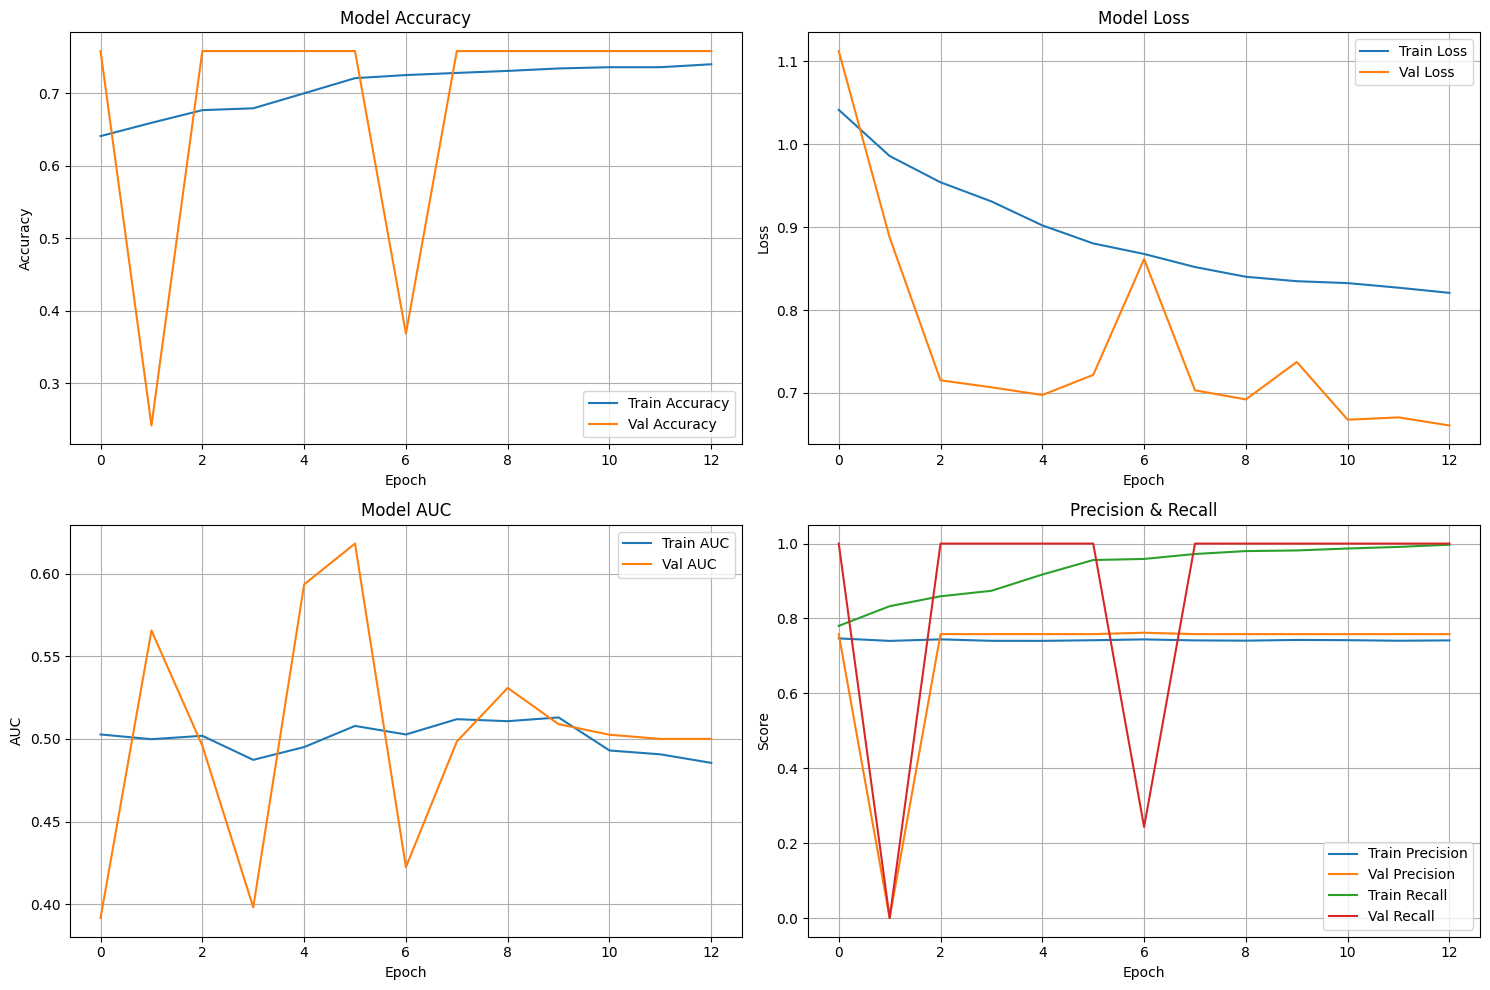

In [ ]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # AUC
    axes[1, 0].plot(history.history['auc'], label='Train AUC')
    axes[1, 0].plot(history.history['val_auc'], label='Val AUC')
    axes[1, 0].set_title('Model AUC')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Precision & Recall
    axes[1, 1].plot(history.history['precision'], label='Train Precision')
    axes[1, 1].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Precision & Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(history)


In [ ]:
print("\n" + "="*50)
print("EVALUATING ON TEST SET")
print("="*50)

results = model.evaluate(test_ds, return_dict=True, verbose=1)
print("\nTest Results:")
for metric, value in results.items():
    print(f"  {metric}: {value:.4f}")


EVALUATING ON TEST SET
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.2984 - auc: 0.3344 - loss: 0.9506 - precision: 0.2984 - recall: 0.6667

Test Results:
  accuracy: 0.6250
  auc: 0.5047
  loss: 0.7890
  precision: 0.6250
  recall: 1.0000


In [ ]:
y_true = np.concatenate([y for _, y in test_ds]).astype(int).ravel()
y_prob = model.predict(test_ds, verbose=0).ravel()

# Find optimal threshold using F1 score
precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

# Generate predictions with optimal threshold
y_pred = (y_prob >= best_threshold).astype(int)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Calculate metrics
specificity = tn / (tn + fp + 1e-9)
sensitivity = tp / (tp + fn + 1e-9)  # Same as recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_prob)

print("\n" + "="*50)
print("DETAILED PERFORMANCE METRICS")
print("="*50)
print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {tn:4d}")
print(f"  False Positives: {fp:4d}")
print(f"  False Negatives: {fn:4d}")
print(f"  True Positives:  {tp:4d}")
print(f"\nMetrics:")
print(f"  Accuracy:    {(tp+tn)/(tp+tn+fp+fn):.4f}")
print(f"  Precision:   {precision:.4f}")
print(f"  Recall:      {recall:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  F1 Score:    {f1:.4f}")
print(f"  AUC-ROC:     {auc_roc:.4f}")
print("="*50)



DETAILED PERFORMANCE METRICS
Optimal Threshold: 0.6087

Confusion Matrix:
  True Negatives:     0
  False Positives:  234
  False Negatives:    0
  True Positives:   390

Metrics:
  Accuracy:    0.6250
  Precision:   0.6250
  Recall:      1.0000
  Specificity: 0.0000
  F1 Score:    0.7692
  AUC-ROC:     0.5340
